# Phase Diagram in 3D

## 1. Setup

In [ ]:
import numpy as np
from scipy import integrate
import matplotlib.pyplot as plt
from scipy.optimize import root_scalar

t = 1
d = 3

def I_1(x):
    if np.abs(x) < 2*t:
        result = np.heaviside(x + 2*t, 1) - (1 / np.pi) * np.arccos(x / (2*t))
    else:
        result = np.heaviside(x + 2*t, 1)
    return result

def I_3(x):
    I_1_shifted = lambda k1, k2: I_1(x + 2 * t * (np.cos(k1) + np.cos(k2)))

    integral_val = integrate.dblquad(I_1_shifted, -np.pi, np.pi, -np.pi, np.pi, epsabs=1e-4)

    return_val = integral_val[0] / ((2 * np.pi)**2)

    return return_val

def rho_3d(mu, U):
    if U >= 0:
        return I_3(mu) + I_3(mu - U)
    elif U < 0:
        return 2 * I_3(mu - U/2)

def find_mu_of_rho(rho, U):
    bracket = (-2*t*d, U + 2*t*d) # minimal and maximal values of mu
    func_mu = lambda mu: rho_3d(mu, U) - rho
    result = root_scalar(func_mu, bracket=bracket, method='brentq', xtol=1e-3)

    if result.converged:
        return result.root
    else:
        raise RuntimeError(f"Keine Nullstelle gefunden für rho={rho}")

def create_mu_list(rho_array, U):
    mu_values = []
    for rho_i in rho_array:
        print(f'\rProgress: {(rho_i/2 * 100):.1f}%{' ' * 20}', end="", flush=True)
        try:
            mu = find_mu_of_rho(rho_i, U)
            mu_values.append(mu)
        except RuntimeError:
            mu_values.append(np.nan)
            print(f"Keine Nullstelle gefunden für rho={rho_i}")
    return mu_values

def one_plot(x_array, y_array,x_label, y_label, title):
    plt.figure(dpi=100)
    # Plot erstellen
    plt.plot(x_array, y_array, linestyle='-')
    
    # Achsenbeschriftungen und Titel
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.grid(True)
    plt.show() 

### Testing Setup

Progress: 2.0%                    

/usr/lib/python3/dist-packages/scipy/integrate/_quadpack_py.py:1233: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Progress: 14.0%                    

/usr/lib/python3/dist-packages/scipy/integrate/_quadpack_py.py:1233: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Progress: 98.0%                    

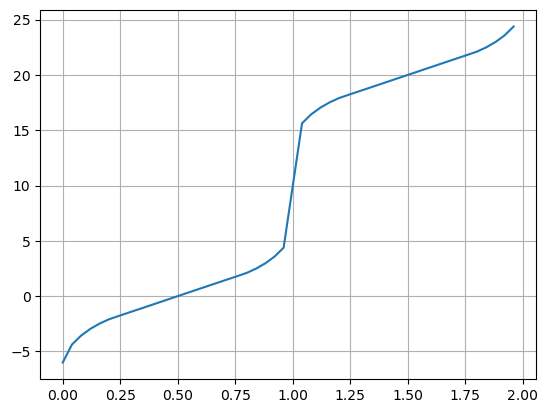

In [6]:
rho_values = np.linspace(0, 2, 50, endpoint=False)

mu_values = create_mu_list(rho_values, 20)

one_plot(rho_values, mu_values, '','','')

## 2. Find $U_c(\rho)$

### Setup

In [ ]:
def find_U_c_of_rho(rho):
    if rho <= 1:
        func_U = lambda U: find_mu_of_rho(rho, U) + 2*t*d - U
        result = root_scalar(func_U, bracket=(0, 4*t*d), method='brentq', xtol=1e-2)
    elif rho > 1:
        func_U = lambda U: find_mu_of_rho(rho, U) - 2*t*d
        result = root_scalar(func_U, bracket=(0, 4*t*d), method='brentq', xtol=1e-2)

    if result.converged:
        return result.root
    else:
        print(result.flag)
        raise RuntimeError(f"Keine Nullstelle gefunden für rho={rho}")
    
def create_U_c_array(rho_array):
    U_c_list = []

    for rho_i in rho_array:
        print(f'\rProgress: {(rho_i/2 * 100):.1f}%{' ' * 20}', end="", flush=True)
        try:
            U_i = find_U_c_of_rho(rho_i)
            U_c_list.append(U_i)
        except RuntimeError:
            U_c_list.append(np.nan)
            print(f"Keine Nullstelle gefunden für rho={rho_i}")

    U_c_array = np.array(U_c_list)

    return U_c_array

### Calculation

In [10]:
rho_values = np.linspace(0, 2, 50, endpoint=False)
U_c_array = create_U_c_array(rho_values)

Progress: 4.0%                    

KeyboardInterrupt: 

idea to improve efficiency: instead of dblquad, evaluate I_1 on a grid and integrate using np.trapz or integrate.simps